In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
#nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)

In [3]:
train_df.head()

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0


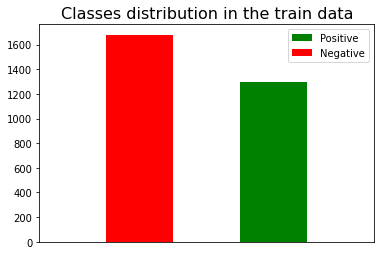

In [4]:
plt.hist(train_df[train_df.label == 1].label,
         bins=2, color='green', label='Positive')
plt.hist(train_df[train_df.label == 0].label,
         bins=2, color='red', label='Negative')
plt.title('Classes distribution in the train data', fontsize=16)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [5]:
print(train_df.isnull().sum())

text      0
aspect    0
label     0
dtype: int64


In [6]:
def tokens(words):
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                 
    return " ".join(text)  

train_df["clear_text"] = train_df['text'].apply(tokens)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,can you check whether its cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely on both milk delivery and grocery ...
2,"I get no notification, however the app is real...",notification,0,i get no notification however the app is reall...
3,"Love this app, but would love it even more if ...",view,1,love this app but would love it even more if g...
4,it does not let me load a clip on the scene,load,0,it does not let me load a clip on the scene


In [7]:
stop_words = stopwords.words('english') + list(string.punctuation)
def stopwords(review):
    text = [word.lower() for word in review.split() if word.lower() not in stop_words]
    return " ".join(text)

train_df['clear_text'] = train_df['clear_text'].apply(stopwords)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery items
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt charts calendar...
4,it does not let me load a clip on the scene,load,0,let load clip scene


In [8]:
# The next step is the normalization of words in the corpus by transform all of different forms of the word into one. 
# The two methods that exist for this purpose are Stemming and Lemmatization. We used the Lemmatization one.
lem = WordNetLemmatizer()

def lemma(text):
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)

train_df['clear_text'] = train_df['clear_text'].apply(lemma)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery item
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt chart calendar ...
4,it does not let me load a clip on the scene,load,0,let load clip scene


# Approach 1: using ml algorithms { Test Accuracy: 66.3% }

In [9]:
positive = train_df[train_df.label== 1]
negative = train_df[train_df.label== 0]
positive.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt chart calendar ...
6,unlimited yearly at $216/year,yearly,1,unlimited yearly year
8,Would love the ability to “un-delete” deleted ...,tasks,1,would love ability un delete deleted task app ...
11,-&gt; i want to learn for the future whether w...,learn,1,gt want learn future whether team something wr...


In [10]:
negative.head()

,text,aspect,label,clear_text
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery item
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
4,it does not let me load a clip on the scene,load,0,let load clip scene
7,"some times missing to deliver, some times diff...","deliver,",0,time missing deliver time different order deli...
10,so i wanted to download the app.,app,0,wanted download app


In [11]:
positive_words =[]

for review in positive.clear_text:
    positive_words.append(review) 
positive_words = ' '.join(positive_words)
positive_words[:48]

'check whether cancelled completely love app woul'

In [12]:
negative_words = []

for review in negative.clear_text:
    negative_words.append(review)
negative_words = ' '.join(negative_words)
negative_words[:45]

'cannot rely milk delivery grocery item get no'

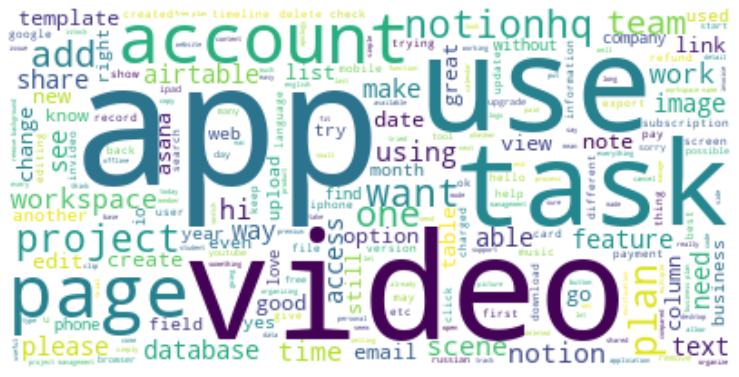

In [13]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=len(positive_words))

wordcloud.generate(positive_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

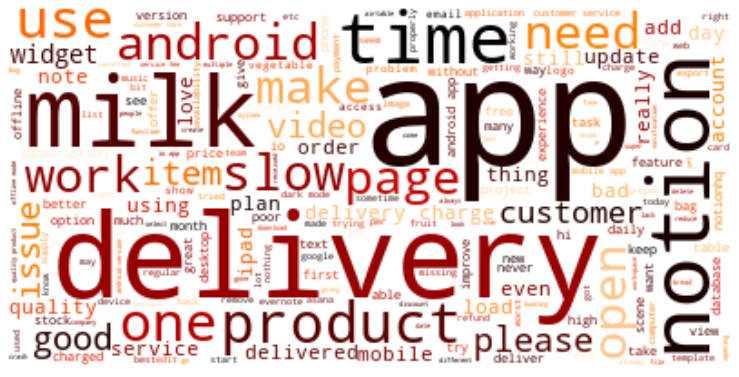

In [14]:
wordcloud = WordCloud(background_color="white", max_words=len(negative_words), colormap='gist_heat')

wordcloud.generate(negative_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [16]:
X = train_df['clear_text']
y = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [17]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

len(vect.get_feature_names())

1095

## Logistic Regression: 66.3%

In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train, )

ytest = np.array(y_test)
predictions = model.predict(vect.transform(X_test))

In [19]:
print('accuracy %s' % accuracy_score(predictions, y_test))
print(classification_report(ytest, predictions))

accuracy 0.66375
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       345
           1       0.68      0.66      0.67       267
           2       0.58      0.59      0.59       188

    accuracy                           0.66       800
   macro avg       0.65      0.65      0.65       800
weighted avg       0.66      0.66      0.66       800



In [20]:
from sklearn.ensemble import RandomForestClassifier
model_rf = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                    ('clf-rf', RandomForestClassifier(n_estimators=50)),
                    ])

model_rf.fit(X_train, y_train)

ytest = np.array(y_test)
pred = model_rf.predict(X_test)

In [21]:
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.66375
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       345
           1       0.66      0.69      0.67       267
           2       0.64      0.52      0.57       188

    accuracy                           0.66       800
   macro avg       0.66      0.64      0.65       800
weighted avg       0.66      0.66      0.66       800



# Approach 2: RNN Classifier { Validation Accuracy: 45% }

In [9]:
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating

from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.layers import SpatialDropout1D, Dropout  # drop out layers

In [25]:
df = train_df.copy(deep=True)
df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery item
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt chart calendar ...
4,it does not let me load a clip on the scene,load,0,let load clip scene


In [27]:
x_data = df.drop(['text', 'aspect', 'label'], axis=1)
x_data = x_data.rename(columns={"clear_text":"review"})
x_data.head()

,review
0,check whether cancelled completely
1,cannot rely milk delivery grocery item
2,get notification however app really fine
3,love app would love even gantt chart calendar ...
4,let load clip scene


In [28]:
y_data = df.drop(['text', 'aspect', 'clear_text'], axis=1)
y_data.head()

,label
0,1
1,0
2,0
3,1
4,0


In [29]:
X = x_data.review
y = y_data.label

In [30]:
print("Training Set X Items: " + str(len(X)))
print("Training Set y Items: " + str(len(y)))

Training Set X Items: 4000
Training Set y Items: 4000


In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
y_training = y_train.values
y_validation = y_valid.values

In [33]:
vocab = X_train.values
vocab

array(['entered email sign immediately error message data read',
       'copy paste whole list do todoist',
       'remove ace membership service fee', ...,
       'improve quality vegetable availability item',
       'want know current plan paid',
       'enjoy notion desktop much mobile app android virtually unusable'],
      dtype=object)

In [34]:
# Vectorize a text corpus, by turning each text into sequence of integers

tokenizer = Tokenizer(num_words=3200,oov_token='OOV')
tokenizer.fit_on_texts(vocab)

vocab_size = len(tokenizer.word_index) + 1

print(tokenizer)
print(vocab_size)

3611


In [43]:
# Store and Padding Converted Sequences
review = X_train.values
review_seqs = tokenizer.texts_to_sequences(review)
padded_sequence_train = pad_sequences(review_seqs, maxlen=10, padding='post', truncating='post', value=0)

docs = X_valid.values
docs_seqs = tokenizer.texts_to_sequences(docs)
padded_sequence_valid = pad_sequences(docs_seqs, maxlen=10, padding='post', truncating='post', value=0)

print(padded_sequence_train[0])
print("***************************************************")
print(padded_sequence_valid[0])

[1379   63  332  552  391  429  215  901    0    0]
***************************************************
[ 199 1267 1072  340  168   53  104   41  830    1]


In [44]:
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=10) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 32)            115552    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 10, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 132,203
Trainable params: 132,203
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
model.fit(padded_sequence_train, y_training, batch_size=128, epochs=10, verbose=1, validation_data=(padded_sequence_valid, y_validation))

Epoch 1/10
25/25 [==============================] - 1s 23ms/step - loss: 0.6281 - accuracy: 0.3369 - val_loss: 0.5053 - val_accuracy: 0.2975
Epoch 2/10
25/25 [==============================] - 0s 10ms/step - loss: 0.3844 - accuracy: 0.3300 - val_loss: 0.3401 - val_accuracy: 0.2975
Epoch 3/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0139 - accuracy: 0.3569 - val_loss: -0.1395 - val_accuracy: 0.3963
Epoch 4/10
25/25 [==============================] - 0s 11ms/step - loss: -0.8168 - accuracy: 0.5194 - val_loss: -0.3250 - val_accuracy: 0.4400
Epoch 5/10
25/25 [==============================] - 0s 11ms/step - loss: -1.4200 - accuracy: 0.5562 - val_loss: -0.4988 - val_accuracy: 0.4363
Epoch 6/10
25/25 [==============================] - 0s 11ms/step - loss: -1.9692 - accuracy: 0.5716 - val_loss: -0.7537 - val_accuracy: 0.4487
Epoch 7/10
25/25 [==============================] - 0s 11ms/step - loss: -2.3883 - accuracy: 0.5853 - val_loss: -0.8666 - val_accuracy: 0.4462
Epoc